#  Exploring the relative significance of various factors in determining presence of Heart Disease

## Introduction

High blood pressure, unhealthy cholesterol levels, and resting heart rate are some of the main predictors of heart disease (CDC). Blood pressure, when too high, can put stress on the arteries in addition to organs such as the heart and kidneys. Cholesterol is a fat-like substance that can build up on the walls of the arteries and reduce blood flow to the heart. These variables can be changed via medications or lifestyle changes and are therefore worth studying as predictors of heart disease.

We will be trying to find which of the well known predictors of heart disease have the greatest impact on presence. To do this we are using the Heart Disease Dataset which contains variables of sex, age, cholesterol, blood pressure, and smoking status.


## Preliminary Exploratory Data Analysis

We begin by reading our data in from the web. Then clean and wrangle it so that it is clear, and easy to manipulate.

In [12]:
library(tidyverse)
library(tidymodels)
library(dplyr)
# Load in libaries

#Set URL of dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

#Set file path of dataset
file_path <- "processed.cleveland.data"

#Get character vector of Column Names of Dataset
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                  "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target")

#Download dataset into R
download.file(url, destfile = file_path, method = "auto")

#Read dataset into heart_csv
heart_csv <- read_delim("processed.cleveland.data", delim = ",", col_names = column_names)

#Clean dataset
heart_data <- heart_csv |>
    select(age, sex, chol, trestbps, target) |>
    mutate(target = as_factor(ifelse(target > 0, 1, 0)))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chol,trestbps,target
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,233,145,0
67,1,286,160,1
67,1,229,120,1
37,1,250,130,0
41,0,204,130,0
56,1,236,120,0
62,0,268,140,1
57,0,354,120,0
63,1,254,130,1


## Training and Testing 

In [19]:
#Create training and testing split for dataset
heart_split <- initial_split(heart_data, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

## Summary 
To start, we summarized the mean cholesteral and resting blood pressure (on admission to the hospital). This was also sorted into whether the patient had a any prescence of heart disease, or not.

In [14]:

#Create summary dataset 
summary_heart <- heart_train |>
    group_by(target) |>
    summarize(mean_chol = mean(chol, na.rm = TRUE), mean_trestbps = mean(trestbps, na.rm = TRUE))
    
summary_heart

target,mean_chol,mean_trestbps
<fct>,<dbl>,<dbl>
0,239.9837,130.0081
1,252.5673,135.0096


### Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.
Plot age vs heart disease, decide to cut off at some age.



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


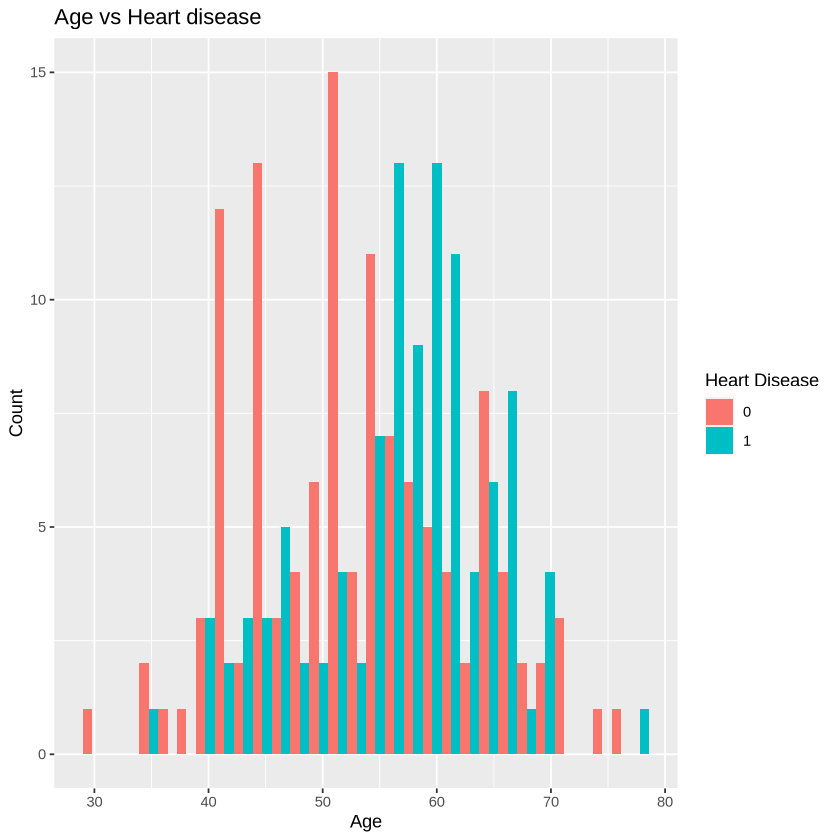

In [18]:
heart_histogram <-   ggplot(heart_train, aes(x = age, fill = target)) +
                     geom_histogram(position = 'dodge') +
                     labs(x = "Age", y = "Count", fill = "Heart Disease") +
                     ggtitle("Age vs Heart disease")
heart_histogram

## Methods

### Variables Used
We will make the data set smaller and more manageable by using the cholesterol, resting heart rate, blood pressure, age, and sex variables. We will also keep the column that determines whether or not the patient received a diagnosis of heart disease in order to train and then test our model. 
### Data Analysis
After cleaning the data and retaining columns for each of our variables, we will split the dataset by sex. We will perform a classification using each variable for one sex and compare the accuracies of each model for that sex. Each classification will start with a training dataset that will be used to create a recipe. We will perform 5-fold cross-validation on the training set in order to find the best k value. Then, we'll build a model using that k value and the training dataset. Finally, we'll use that model to pass the testing dataset through and evaluate its' accuracy. This process will be repeated for each variable for males and then each variable for females.
### Data Visualization
We will visualize results with bar plots that represent the accuracy of each variable, separated by sex. This will demonstrate which variables are best at predicting a diagnosis of heart disease and highlight any discrepancies between sexes. Additionally, we will have confusion matrixes for each variable. We will also have tibbles with each variables' accuracy for each sex. 



## Expected outcomes and significance

### What do you expect to find? 
We expect to find that high cholesterol, high blood pressure, and increased resting heart rate are all positively correlated to a diagnosis of heart disease. We expect to find that cholesterol is the best predictor of heart disease and heart rate is the worst predictor in both sexes.
### What impact could such findings have?
Identifying the best predictor of heart disease also identifies the variable that is most important to change. So, if cholesterol is the best predictor, then one should focus on lowering their cholesterol before worrying about the other variables. 
### What future questions could this lead to?
This could lead to questions about how our diet and lifestyles can be changed to reduce these levels. Additionally, we could wonder if more resources and energy should be targeted toward the identification and treatment of some variables over others. We also may wonder if there are additional variables that we didn't include in our tidied data that could have more of an impact over the variables that we chose to include. 

 Which factors are most prominent in positive diagnoses